## MATCHING DE PUNTOS SEGUN DAHLIA

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Proyecto de grado-Extensión/Registro de Nubes/Registro de Nubes')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1bUVmxKZXlCNnu4CbA53Po31b084HWCvL/Registro de Nubes


In [4]:
import os
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt

In [5]:
!pip install plyfile

In [6]:
from plyfile import PlyData, PlyElement #Libreria para almacenar datos tridimensionales de escáneres 3D. 
import numpy as np
import cv2 #Librería para problemas de visión por computador

In [7]:
os.chdir('/content/drive/MyDrive/PROYECTO DE GRADO/Code')
plydata = PlyData.read('Data/bunny/reconstruction/bun_zipper_res2.ply')

In [8]:
points = []
for point in plydata.elements[0].data:
    points.append([point['x'], point['y'], point['z']])
points = np.array(points)


In [9]:
conejo = points-np.mean(points,0)

In [10]:
SC = conejo[0:5000]

In [11]:
#segundo modelo entrenado
os.chdir('/content/drive/MyDrive/PROYECTO DE GRADO/Code/DPDist-master/log/lastTrain')

## Datos


In [12]:
def read_pc_by_class(num_point_Clouds, num_points, clase, inicial_path):
  import random
  r = random.randint(0, 20)
  lista = []
  path_i = inicial_path + '/' + clase + '/' + clase +'_'
  
  for i in range(1, num_point_Clouds+1):
    if(i<10):
      path = path_i + '00' + str(0)+str(i) + '.txt'
    if(i>=10 and i<100):
      path = path_i + '00' + str(i) + '.txt'
    if(i>=100 and i<1000):
      path = path_i + '0' + str(i) + '.txt'
    if(i>=1000):
      path = path_i + str(i) + '.txt'
    pC = np.loadtxt(path, delimiter=',', usecols=(0,1,2))
    pC = pC[r*100:r*100+num_points, :]
    lista.append(pC)



  return lista


In [13]:
def rotation_matrix(theta):
    return np.array([[np.cos(theta),-np.sin(theta), 0],
                     [np.sin(theta),np.cos(theta), 0],
                     [0,0,1]])

In [14]:
chair = read_pc_by_class(20, 5000, 'chair', '../../data/modelnet40_normal_resampled')

In [15]:
guitar = read_pc_by_class(10, 5000, 'guitar', '../../data/modelnet40_normal_resampled')

In [16]:
nube = chair[2]
SA = nube[:1024,:]
SB =  chair[2][2048:3072,:]

## DPDist

In [17]:
def get_bn_decay(batch):
  bn_momentum = tf.train.exponential_decay(
                                            0.5,
                                            batch,#*BATCH_SIZE,
                                            float(0.5),
                                            0.5,
                                            staircase=True)

In [18]:
def initialize_uninitialized_vars(sess):
    from itertools import compress
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([~(tf.is_variable_initialized(var)) \
                                   for var in global_vars])
    not_initialized_vars = list(compress(global_vars, is_not_initialized))

    if len(not_initialized_vars):
        print('init not_initialized')
        print(not_initialized_vars)
        sess.run(tf.variables_initializer(not_initialized_vars))

In [19]:
def DPDIST(nubeA, nubeB):
  import tensorflow.compat.v1 as tf
  input_1 = nubeA.reshape(16, 64, SB.shape[1])
  input_2 = nubeB.reshape(16,  64 ,SA.shape[1])
  noise = np.zeros((16, 64, 3))
  from tensorflow.python.framework import meta_graph
  graph = tf.Graph()
  with graph.as_default():
    with tf.device('/gpu:' + str(0)):
        batch = tf.get_variable('batch', [], initializer=tf.constant_initializer(0), trainable=False)
        #bn_decay = get_bn_decay(batch)
        #tf.summary.scalar('bn_decay', bn_decay) 
        is_training_pl_1 = tf.placeholder(tf.bool, shape=())
        is_training_pl_2 = tf.placeholder(tf.bool, shape=())
        x1 = tf.placeholder(tf.float32, (16, 64,3), name='input1')
        x2 = tf.placeholder(tf.float32, (16, 64,3), name='input2')
        x3 = tf.placeholder(tf.float32, (16, 64,3), name='input3')
        saver31 = tf.train.import_meta_graph('./model.ckpt.meta',
                                            import_scope='g1',
                                            input_map={'input1': x1,
                                                      'input2': x2,
                                                      'Placeholder': is_training_pl_1,
                                                      'add_noise':x3}
                                            )
        labels12 = graph.get_tensor_by_name('g1/labels12:0')
        pred_AB3 = (graph.get_tensor_by_name('g1/pc_compare/output1:0'))
        pred_BA3 = (graph.get_tensor_by_name('g1/pc_compare/output2:0'))
        loss_p = (tf.reduce_mean(pred_AB3[:,:,:,0]) + tf.reduce_mean(pred_BA3[:,:,:,0]))/2.0
    # Create a session
    init = tf.global_variables_initializer()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = False
    sess3 = tf.InteractiveSession(config=config)
    sess3.run(init)
    #DPDist weights loader
    MODEL_PATH = './model.ckpt'
    saver31.restore(sess3, MODEL_PATH)
    initialize_uninitialized_vars(sess3)
    #print('model restored')
    ops3 = {'x1':x1,
            'x2':x2,
            'add_noise':x3,
            # 'pc_Crec':pc_Crec,
            'is_training_pl1':is_training_pl_1,
            'loss':loss_p,
            'labels12':labels12,
            'pred': {'pred_AB':pred_AB3,'pred_BA':pred_BA3}}

    feed_dict={ops3['x1']:input_1,
              ops3['x2']: input_2,
              ops3['is_training_pl1']:False,
              ops3['add_noise']:noise,
              # train_opt_pred3:True,
              }        
    result =sess3.run([ops3['pred']], feed_dict=feed_dict)
    '''
    resultBA=sess3.run(pred_BA3, feed_dict=feed_dict_testing)
    resultAB_0 = resultAB[:,:,:,:]
    resultBA_0 = resultBA[:,:,:,:]  
    resultAB_0 = resultAB_0.reshape(1024,3)
    resultBA_0 = resultAB_0.reshape(1024,3)
    '''
   
    sess3.close()
    result = np.array(result)
    DistAB = result[0]['pred_AB']
    vDistAB = DistAB.reshape(1024,3)
    DistBA = result[0]['pred_BA']
    vDistBA = DistBA.reshape(1024,3)
  return vDistAB, vDistBA,  #vectores de distanciaAB, #vectores de distanciaBA

In [20]:
def DPDISTnormaAndDistPc_Pc(vectorDistAB, vectorDistBA):
  DPDistanceABmap = []
  for i in range(len(vectorDistAB)):
    DPDistanceAB = np.linalg.norm(vectorDistAB[i,:])
    DPDistanceABmap.append(DPDistanceAB)
  DPDistanceABmap = np.array(DPDistanceABmap)

  DPDistanceBAmap = []
  for i in range(len(vectorDistBA)):
    DPDistanceBA= np.linalg.norm(vectorDistBA[i,:])
    DPDistanceBAmap.append(DPDistanceBA)
  DPDistanceBAmap = np.array(DPDistanceBAmap)

  dist_pcA_pcB=((1/SA.shape[0])*np.sum(DPDistanceABmap))+((1/SB.shape[0])*np.sum(DPDistanceBAmap))

  return DPDistanceABmap, DPDistanceBAmap, round(dist_pcA_pcB, 4) #normaVectoresAB, #normaVectoresBA, #distancia de nube a nube 

In [21]:
def get_bn_decay(batch):
  bn_momentum = tf.train.exponential_decay(
                                            0.5,
                                            batch,#*BATCH_SIZE,
                                            float(0.5),
                                            0.5,
                                            staircase=True)

In [22]:
def initialize_uninitialized_vars(sess):
    from itertools import compress
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([~(tf.is_variable_initialized(var)) \
                                   for var in global_vars])
    not_initialized_vars = list(compress(global_vars, is_not_initialized))

    if len(not_initialized_vars):
        print('init not_initialized')
        print(not_initialized_vars)
        sess.run(tf.variables_initializer(not_initialized_vars))

## Funciones de rotación

In [23]:
import math
from functools import reduce
import numpy as np
def rotacionZYX(radz, rady, radx):
  Ms = []
  z= radz
  y= rady
  x= radx

  cosz = math.cos(z)
  sinz = math.sin(z)
  Ms.append(np.array(
          [[cosz, -sinz, 0],
            [sinz, cosz, 0],
            [0, 0, 1]]))

  cosy = math.cos(y)
  siny = math.sin(y)
  Ms.append(np.array(
          [[cosy, 0, siny],
            [0, 1, 0],
            [-siny, 0, cosy]]))

  cosx = math.cos(x)
  sinx = math.sin(x)
  Ms.append(np.array(
          [[1, 0, 0],
            [0, cosx, -sinx],
            [0, sinx, cosx]]))


  Mzxy = reduce(np.dot, Ms[::-1])
  return Mzxy

In [24]:
def rotation_matrix(theta):
    return np.array([[1,0, 0],
                     [0,np.cos(theta), -np.sin(theta)],
                     [0,np.sin(theta), np.cos(theta)]])

In [25]:
def Y_axis_rotation_matrix(theta):
    return np.array([[np.cos(theta),  0,  np.sin(theta)],
                     [0,              1,              0],
                     [-np.sin(theta), 0,  np.cos(theta)]])

In [26]:
def Z_axis_rotation_matrix(theta):
    return np.array([[np.cos(theta),   -np.sin(theta),    0],
                     [np.sin(theta),    np.cos(theta),    0],
                     [0,                0,                1]])

p1+DPDist(p1,pc2) ~ p2)

##### Nubes rotadas pi/2

In [27]:
nube = chair[0]
SA = nube[:1024,:]
SB = nube[2048:3072,:]

In [28]:
import random

r = random.randint(1,10)
rt = random.random()
Rm = rotation_matrix(np.pi/2)
SB= np.dot(Rm,SB.T).T 

In [29]:
SA[0]

array([0.1488, 0.7387, 0.4303])

In [30]:
SB.shape

(1024, 3)

In [31]:
vectDistAB, vectDistBA = DPDIST(SA, SB)
normAB, normBA, DistPC_PC = DPDISTnormaAndDistPc_Pc(vectDistAB, vectDistBA)

INFO:tensorflow:Restoring parameters from ./model.ckpt


In [32]:
vectDistAB[:,:]

array([[0.3426527 , 0.04551411, 0.        ],
       [0.16194792, 0.03772355, 0.        ],
       [0.58235645, 0.0420653 , 0.        ],
       ...,
       [0.29869625, 0.03031563, 0.        ],
       [0.        , 0.01159101, 0.        ],
       [0.2338372 , 0.06246928, 0.        ]], dtype=float32)

In [33]:
len(vectDistAB[:,1])

1024

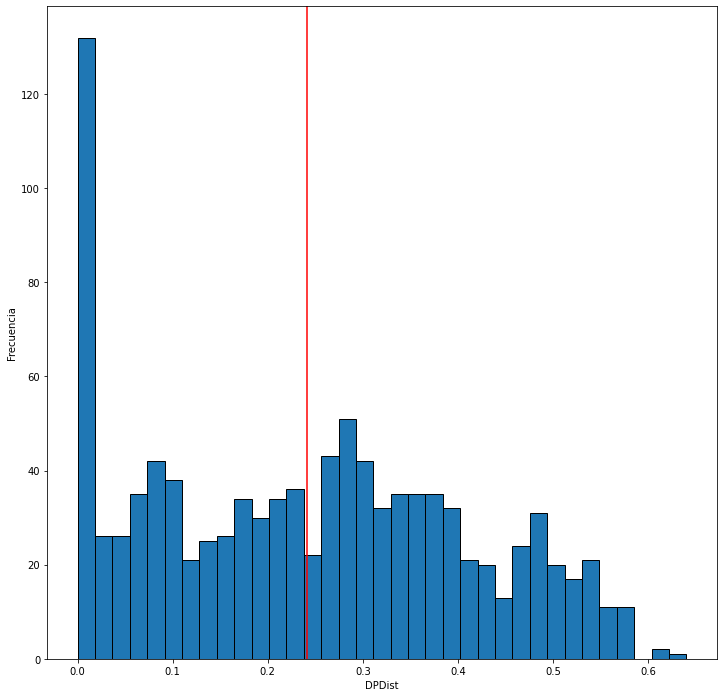

In [34]:
media = np.mean(vectDistAB[:,0])
fig = plt.figure(figsize=(12,12))
plt.hist(vectDistAB[:,0],edgecolor="black",bins=35)
plt.ylabel('Frecuencia');
plt.xlabel('DPDist');
plt.axvline(media, color='red')

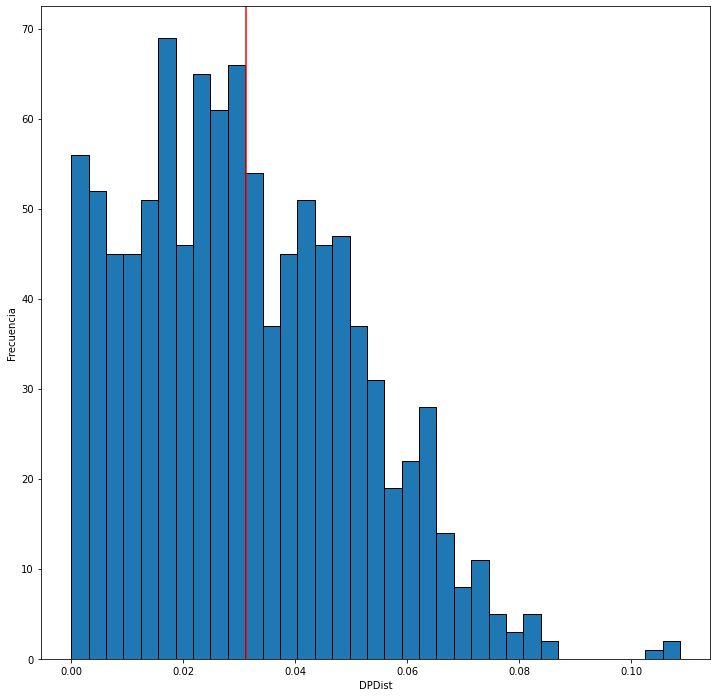

In [35]:

media = np.mean(vectDistAB[:,1])
fig = plt.figure(figsize=(12,12))
plt.hist(vectDistAB[:,1],edgecolor="black",bins=35)
plt.ylabel('Frecuencia');
plt.xlabel('DPDist');
plt.axvline(media, color='red')

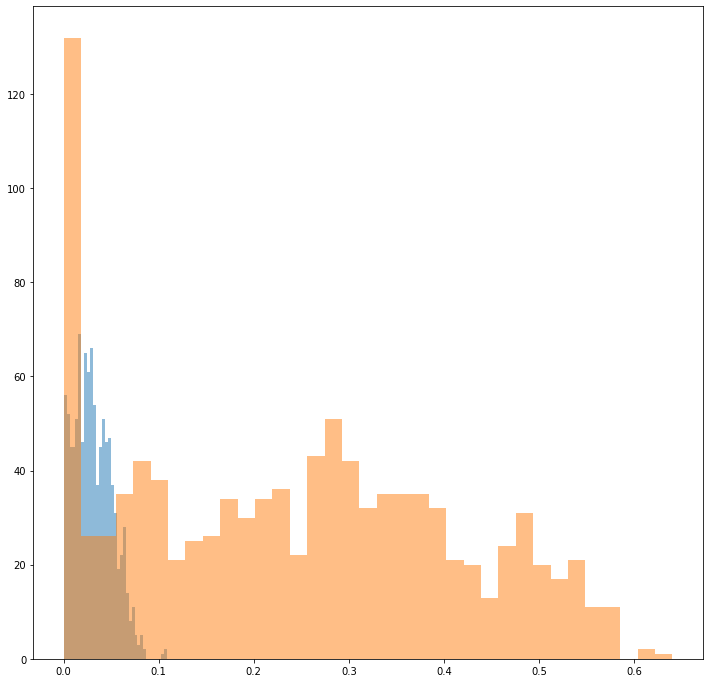

In [36]:
fig = plt.figure(figsize=(12,12))
plt.hist(vectDistAB[:,1], histtype="stepfilled",alpha=0.5, bins=35)
plt.hist(vectDistAB[:,0], histtype="stepfilled",alpha=0.5, bins=35)
plt.show()

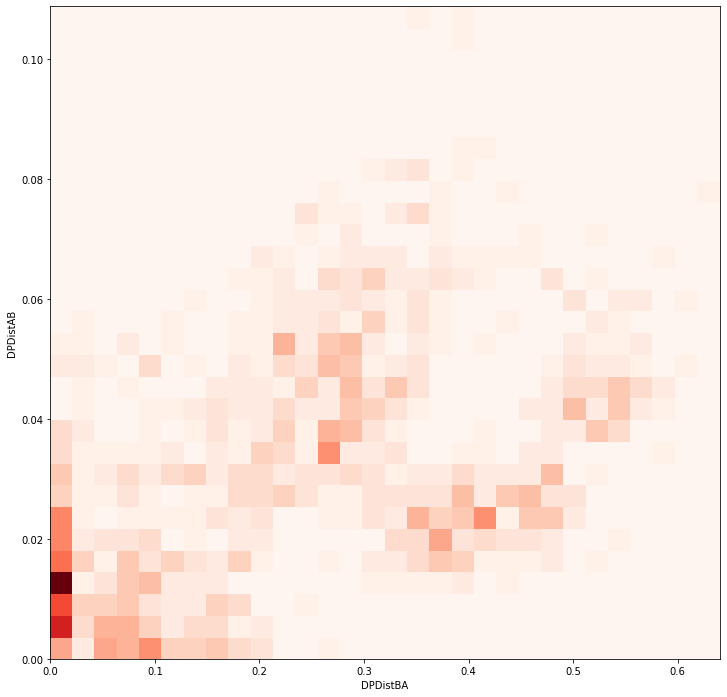

In [37]:
fig = plt.figure(figsize=(12,12))
plt.hist2d(vectDistAB[:,0],vectDistAB[:,1], bins=30, cmap='Reds')
plt.ylabel('DPDistAB');
plt.xlabel('DPDistBA');
plt.show()

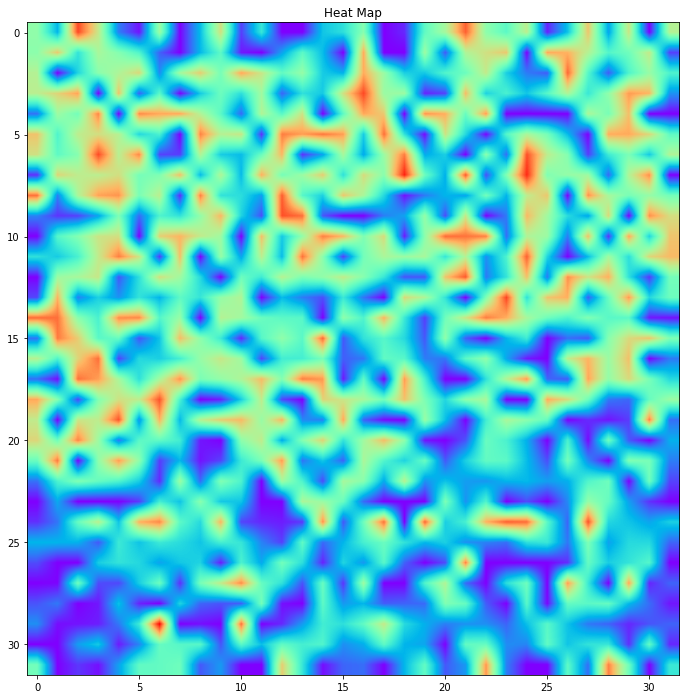

In [38]:
x = vectDistAB[:,0].reshape(32,32)

# Heat map
fig = plt.figure(figsize=(12,12))
plt.imshow( x, cmap = 'rainbow' , interpolation = 'bilinear')

# Add Title

plt.title( "Heat Map" )

# Display

plt.show()

In [ ]:
x = vectDistAB[:,1].reshape(1024,3)

# Heat map
fig = plt.figure(figsize=(12,12))
plt.imshow( x, cmap = 'rainbow' , interpolation = 'bilinear')

# Add Title

plt.title( "Heat Map" )

# Display

plt.show()

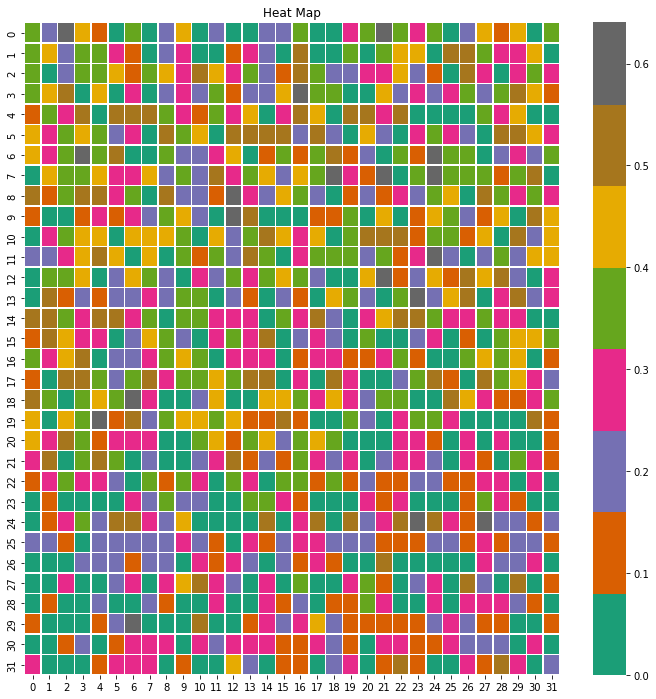

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
  
# Define Data Coordinates

fig = plt.figure(figsize=(12,12))
x = vectDistAB[:,0].reshape(32,32)

# HeatMap


sns.heatmap( x , linewidth = 0.5 , cmap = 'Dark2' )

# Add Title


plt.title( "Heat Map" )

# Display

plt.show()

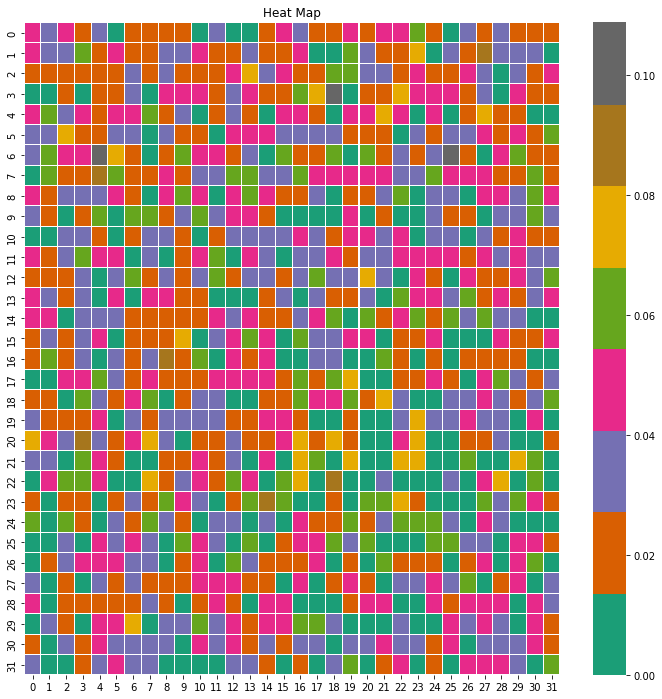

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
  
# Define Data Coordinates
fig = plt.figure(figsize=(12,12))

x = vectDistAB[:,1].reshape(32,32)

# HeatMap


sns.heatmap( x , linewidth = 0.01 , cmap = 'Dark2' )

# Add Title


plt.title( "Heat Map" )

# Display

plt.show()

##### Nubes rotadas 3pi/2

In [42]:
nube = chair[0]
SA = nube[:1024,:]
SB = nube[2048:3072,:]

In [43]:
import random

r = random.randint(1,10)
rt = random.random()
Rm = rotation_matrix(3*np.pi/2)
SB= np.dot(Rm,SB.T).T 

In [44]:
SA[0]

array([0.1488, 0.7387, 0.4303])

In [45]:
SB.shape

(1024, 3)

In [46]:
vectDistAB, vectDistBA = DPDIST(SA, SB)
normAB, normBA, DistPC_PC = DPDISTnormaAndDistPc_Pc(vectDistAB, vectDistBA)

INFO:tensorflow:Restoring parameters from ./model.ckpt


In [47]:
vectDistAB[:,:]

array([[0.39393806, 0.01991639, 0.        ],
       [0.25060824, 0.0242677 , 0.        ],
       [0.5458451 , 0.07182612, 0.        ],
       ...,
       [0.24818687, 0.03877145, 0.        ],
       [0.        , 0.01168855, 0.        ],
       [0.33970454, 0.03165971, 0.        ]], dtype=float32)

In [48]:
len(vectDistAB[:,1])

1024

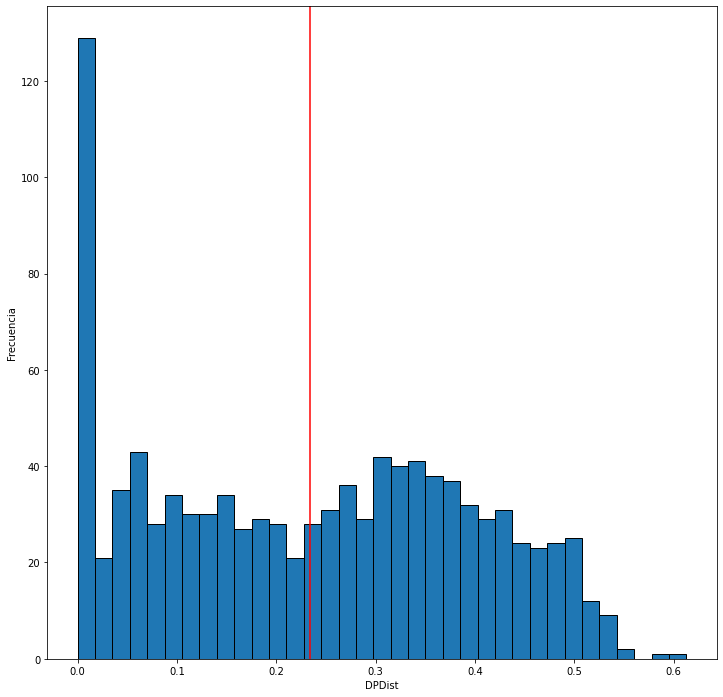

In [49]:
media = np.mean(vectDistAB[:,0])
fig = plt.figure(figsize=(12,12))
plt.hist(vectDistAB[:,0],edgecolor="black",bins=35)
plt.ylabel('Frecuencia');
plt.xlabel('DPDist');
plt.axvline(media, color='red')

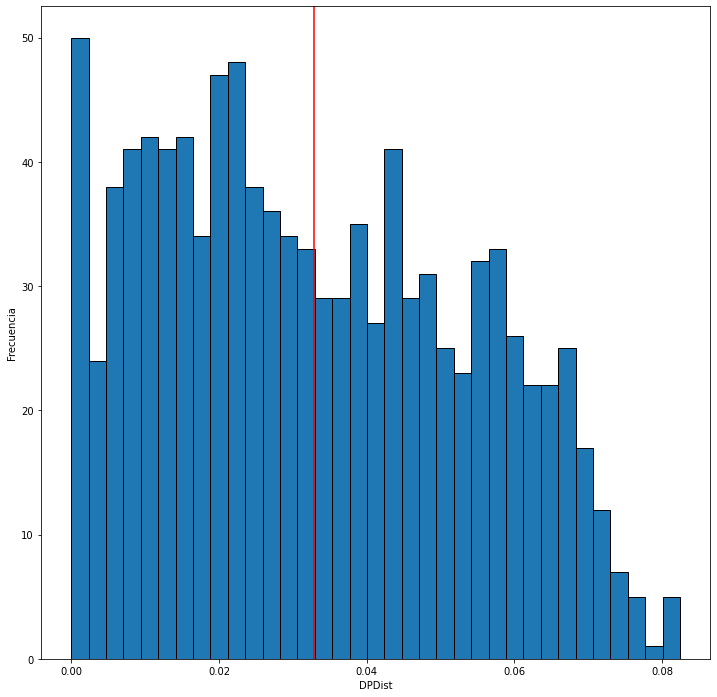

In [50]:

media = np.mean(vectDistAB[:,1])
fig = plt.figure(figsize=(12,12))
plt.hist(vectDistAB[:,1],edgecolor="black",bins=35)
plt.ylabel('Frecuencia');
plt.xlabel('DPDist');
plt.axvline(media, color='red')

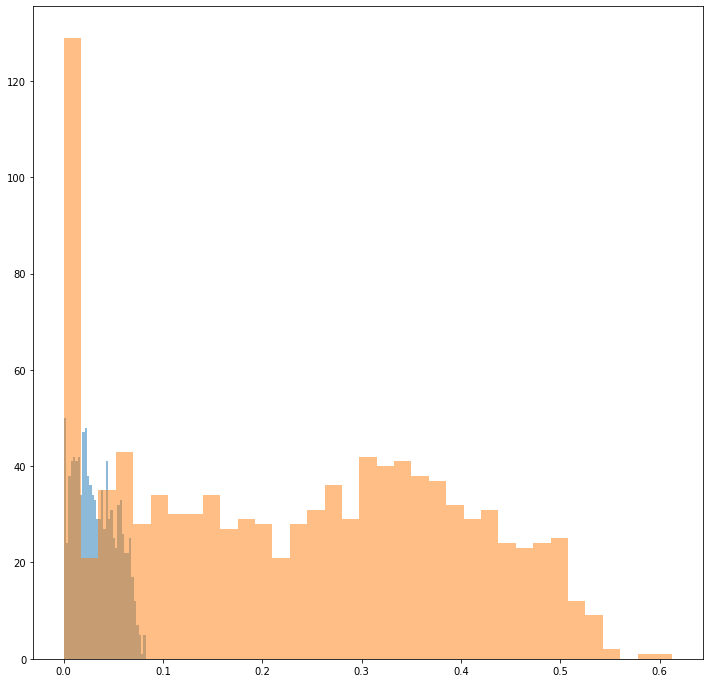

In [51]:
fig = plt.figure(figsize=(12,12))
plt.hist(vectDistAB[:,1], histtype="stepfilled",alpha=0.5, bins=35)
plt.hist(vectDistAB[:,0], histtype="stepfilled",alpha=0.5, bins=35)
plt.show()

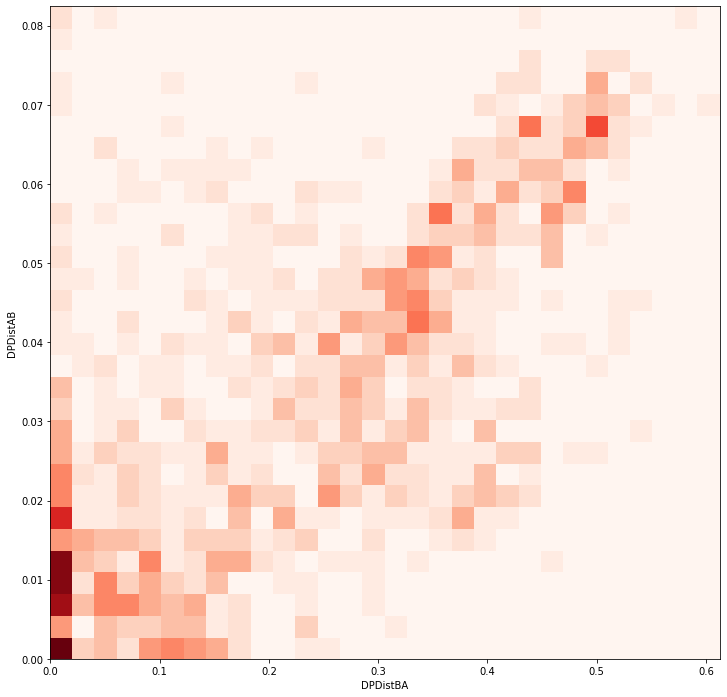

In [52]:
fig = plt.figure(figsize=(12,12))
plt.hist2d(vectDistAB[:,0],vectDistAB[:,1], bins=30, cmap='Reds')
plt.ylabel('DPDistAB');
plt.xlabel('DPDistBA');
plt.show()

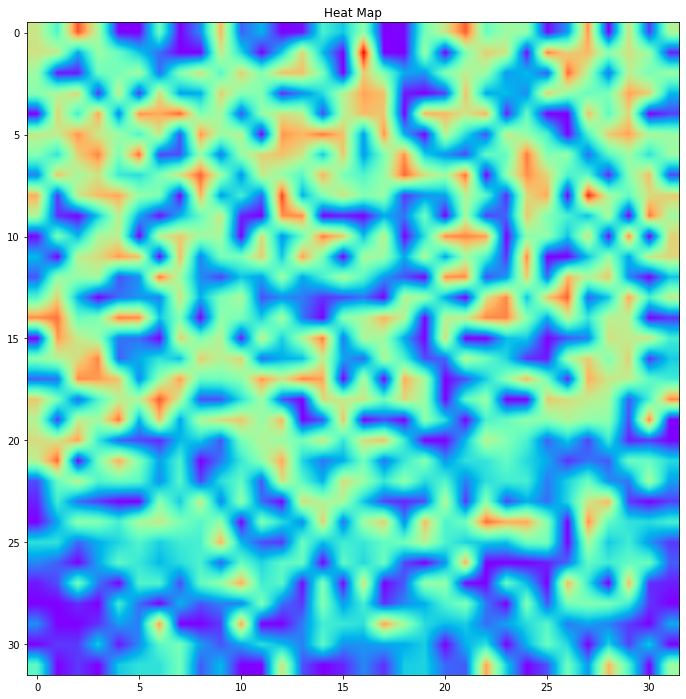

In [53]:
x = vectDistAB[:,0].reshape(32,32)

# Heat map
fig = plt.figure(figsize=(12,12))
plt.imshow( x, cmap = 'rainbow' , interpolation = 'bilinear')

# Add Title

plt.title( "Heat Map" )

# Display

plt.show()

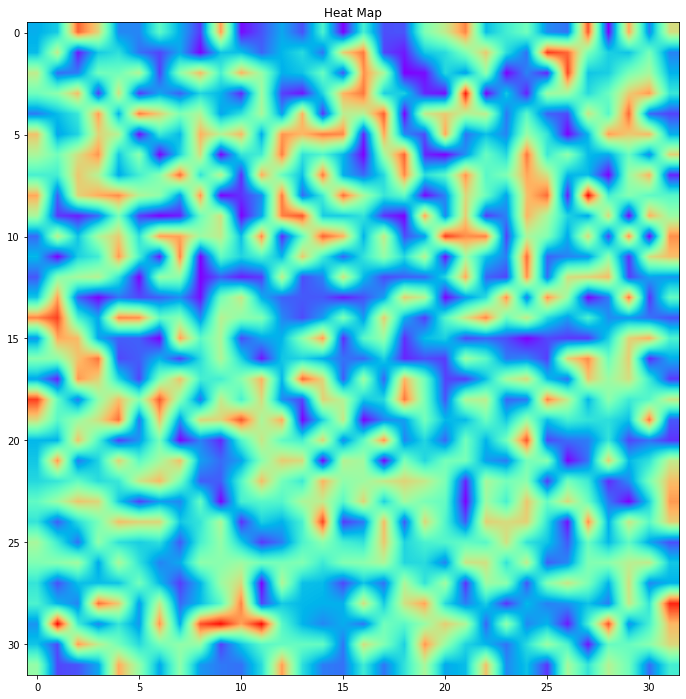

In [54]:
x = vectDistAB[:,1].reshape(32,32)

# Heat map
fig = plt.figure(figsize=(12,12))
plt.imshow( x, cmap = 'rainbow' , interpolation = 'bilinear')

# Add Title

plt.title( "Heat Map" )

# Display

plt.show()

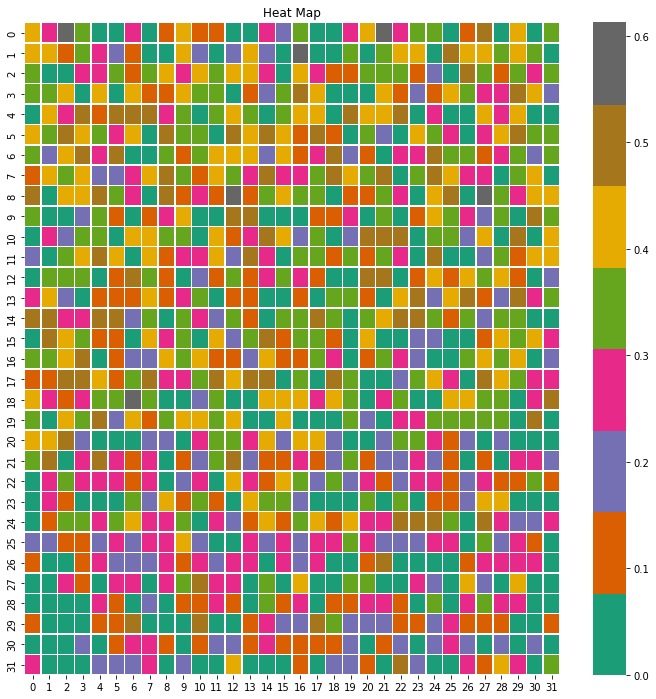

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
  
# Define Data Coordinates

fig = plt.figure(figsize=(12,12))
x = vectDistAB[:,0].reshape(32,32)

# HeatMap


sns.heatmap( x , linewidth = 0.5 , cmap = 'Dark2' )

# Add Title


plt.title( "Heat Map" )

# Display

plt.show()

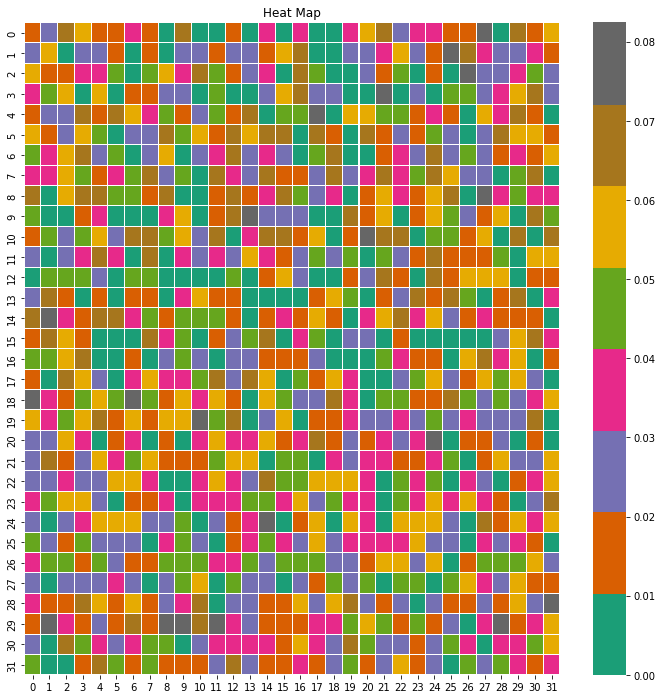

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
  
# Define Data Coordinates
fig = plt.figure(figsize=(12,12))

x = vectDistAB[:,1].reshape(32,32)

# HeatMap


sns.heatmap( x , linewidth = 0.01 , cmap = 'Dark2' )

# Add Title


plt.title( "Heat Map" )

# Display

plt.show()

## nubes


In [57]:
#

In [58]:
P=[]
for i in range(len(SA)):
  for j in range(len(SB)):
      P.append(np.linalg.norm(SA[i]-SB[j]))

In [59]:
P = np.array(P)

In [60]:
indAB = []
indBA = []
for i in range(len(P)):
  for j in range(len(normAB)):
    if(np.round(P[i],2)==np.round(normAB[j]),2):
      indAB.append(j)
    if(np.round(P[i],2)==np.round(normBA[j]),2):
      indBA.append(j)

KeyboardInterrupt: ignored

In [ ]:
print(len(indAB), len(indBA))

In [ ]:
normAB

In [ ]:
normBA

In [ ]:
normAB+normBA

In [ ]:
matches = []
for i in range(len(vectDistAB)):
  match  = SA[i] + vectDistBA[i]
  matches.append(match)
matches = np.array(matches)  

In [ ]:
matches[0]

In [ ]:
SB[0]

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = matches[:,0]
Y = matches[:,1]
Z = matches[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

In [ ]:
fig = plt.figure(figsize=(50,20))


ax = fig.add_subplot(1, 3, 1, projection='3d')
X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]

ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('SA')

ax = fig.add_subplot(1, 3, 2, projection='3d')
X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]

ax.scatter3D(X,Z,Y)
ax.set_title('SB')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

ax = fig.add_subplot(1, 3, 3, projection='3d')
X = matches[:,0]
Y = matches[:,1]
Z = matches[:,2]

ax.scatter3D(X,Z,Y)
ax.set_title('Muestra matches')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]
ax.scatter3D(X,Z,Y, label='SB')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = matches[:,0]
Y = matches[:,1]
Z = matches[:,2]
ax.scatter3D(X,Z,Y, label='matches')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

###### DE B a A

In [ ]:
#output DPDist pcA to pcB
vectDistAB

In [ ]:
#output DPDist pcB to pcA
vectDistBA

In [ ]:
matches = []
for i in range(len(vectDistBA)):
  match  = SB[i] + vectDistAB[i]
  matches.append(match)
matches = np.array(matches)  

In [ ]:
matches[0]

In [ ]:
SA[0]

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = matches[:,0]
Y = matches[:,1]
Z = matches[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

In [ ]:
fig = plt.figure(figsize=(50,20))


ax = fig.add_subplot(1, 3, 1, projection='3d')
X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]

ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('SA')

ax = fig.add_subplot(1, 3, 2, projection='3d')
X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]

ax.scatter3D(X,Z,Y)
ax.set_title('Muestra SB')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

ax = fig.add_subplot(1, 3, 3, projection='3d')
X = matches[:,0]
Y = matches[:,1]
Z = matches[:,2]

ax.scatter3D(X,Z,Y)
ax.set_title('Muestra matches')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()

##### Nubes rotadas

In [ ]:
SA = SC[:1024,:]
SB = SC[2048:3072,:]

In [ ]:
import random

r = random.randint(1,10)
rt = random.random()
Rm = rotation_matrix(np.pi/4)
SB= np.dot(Rm,SB.T).T  

###### DE A a B

In [ ]:
SA[0]

In [ ]:
SB[0]

In [ ]:
vectDistAB, vectDistBA = DPDIST(SA, SB)
normAB, normBA, DistPC_PC = DPDISTnormaAndDistPc_Pc(vectDistAB, vectDistBA)

In [ ]:
vectDistBA[0]

In [ ]:
vectDistAB[0]

In [ ]:
matches = []
for i in range(len(vectDistAB)):
  match  = SA[i] + vectDistBA[i]
  matches.append(match)
matches = np.array(matches)  

In [ ]:
matches[0]

In [ ]:
SB[0]

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y) 
X = SB[:,0]
Y = SB[:,1] 
Z = SB[:,2] 
ax.scatter3D(X,Z,Y) 
'''
for i in range(40):
  ax.quiver(SA[i][0], SA[i][2], SA[i][1], matches[i][0], matches[i][2] ,matches[i][1], arrow_length_ratio=0.0001, color='r')
  ax.set_xlim(-0.6,1.1)
  ax.set_ylim(-0.8,1.1)
  ax.set_zlim(-0.7,1.5)
'''
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

In [ ]:
fig = plt.figure(figsize=(50,20))


ax = fig.add_subplot(1, 3, 1, projection='3d')
X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]

ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('SA')

ax = fig.add_subplot(1, 3, 2, projection='3d')
X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]

ax.scatter3D(X,Z,Y)
ax.set_title('SB')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

ax = fig.add_subplot(1, 3, 3, projection='3d')
X = matches[:,0]
Y = matches[:,1]
Z = matches[:,2]

ax.scatter3D(X,Z,Y)
ax.set_title('Muestra matches')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()

###### DE B a A

In [ ]:
matches = []
for i in range(len(vectDistBA)):
  match  = SB[i] + vectDistAB[i]
  matches.append(match)
matches = np.array(matches)  

In [ ]:
matches[0]

In [ ]:
SB[0]

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = matches[:,0]
Y = matches[:,1]
Z = matches[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

In [ ]:
fig = plt.figure(figsize=(50,20))


ax = fig.add_subplot(1, 3, 1, projection='3d')
X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]

ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('SA')

ax = fig.add_subplot(1, 3, 2, projection='3d')
X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]

ax.scatter3D(X,Z,Y)
ax.set_title('SB')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

ax = fig.add_subplot(1, 3, 3, projection='3d')
X = matches[:,0]
Y = matches[:,1]
Z = matches[:,2]

ax.scatter3D(X,Z,Y)
ax.set_title('Muestra matches')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()